In [11]:
import torch
import matplotlib.pyplot as plt
import sigkernel
from torch.distributions import MultivariateNormal
from stein_mpc.inference import SVGD
from stein_mpc.kernels import GaussianKernel, TrajectoryKernel, PathSigKernel

batch = 100
length = 10
channels = 2

class SequentialDist():
    def __init__(self, length, channels):
        dists = []
        for i in range(length):
            loc = torch.randn(channels)
            scale = torch.empty(channels).uniform_(0.1, 0.5).diag()
            dists.append(MultivariateNormal(loc, scale_tril=scale))
        self.dists = dists
        
    def log_prob(self, x, dim=None):
        log_p = 0
        if dim is None:
            for i, dist in enumerate(self.dists):
                log_p += dist.log_prob(x[i])
        elif hasattr(dim, "__iter__"):
            for i in dim:
                log_p += self.dists[i].log_prob(x[i])
        else:
            log_p = self.dists[dim].log_prob(x)

        return log_p

    def plot_2d(self, dim, ax=None, grid_size=100, padding=1):
        ngrid = 100
        x_lim = torch.tensor([-padding, padding]) + self.dists[dim].mean[0]
        y_lim = torch.tensor([-padding, padding]) + self.dists[dim].mean[1]
        x = torch.linspace(*x_lim, grid_size)
        y = torch.linspace(*y_lim, grid_size)
        X, Y = torch.meshgrid(x,y)
        Z = self.dists[dim].log_prob(torch.stack((X.flatten(), Y.flatten()), dim=1))
        Z = Z.exp().reshape(grid_size, grid_size)

        if ax is None:
            plt.figure(figsize = (10, 10))
            ax = plt.gca()
        ax.contourf(X, Y, Z.data.numpy(), 30)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim) 
    # mvn = MultivariateNormal(loc, covariance_matrix=cov)

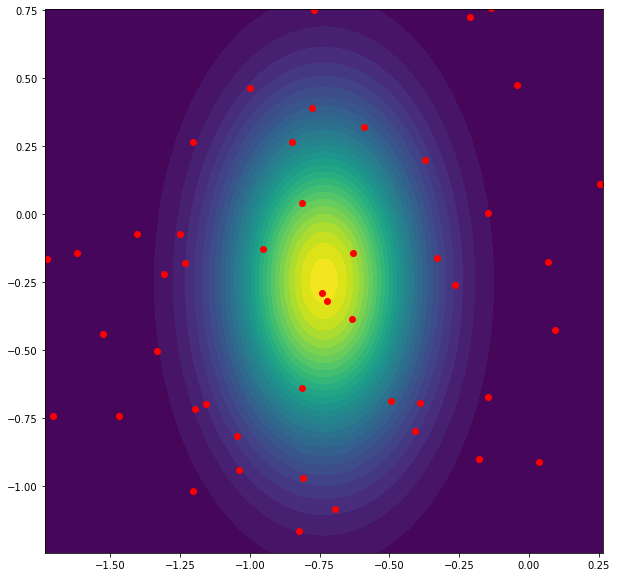

In [2]:
dist = SequentialDist(length, channels)
dist.plot_2d(1)

sample = torch.randn(100, channels) + dist.dists[1].mean
ax = plt.gca()
ax.scatter(sample[:, 0].numpy(), sample[:, 1].numpy(), c="r")


In [3]:
# Sets up the optimization problem
torch.manual_seed(42)
particles = torch.randn(batch, length, channels)
dist = SequentialDist(length, channels)

In [4]:
# Batch optimization using SVGD
n_iter = 500
kernel = GaussianKernel()
stein_sampler = SVGD(kernel, log_p=dist.log_prob, optimizer_class=torch.optim.Adam, lr=0.1)

stein_sampler.optimize(particles, n_steps=n_iter)
particles = particles.detach()

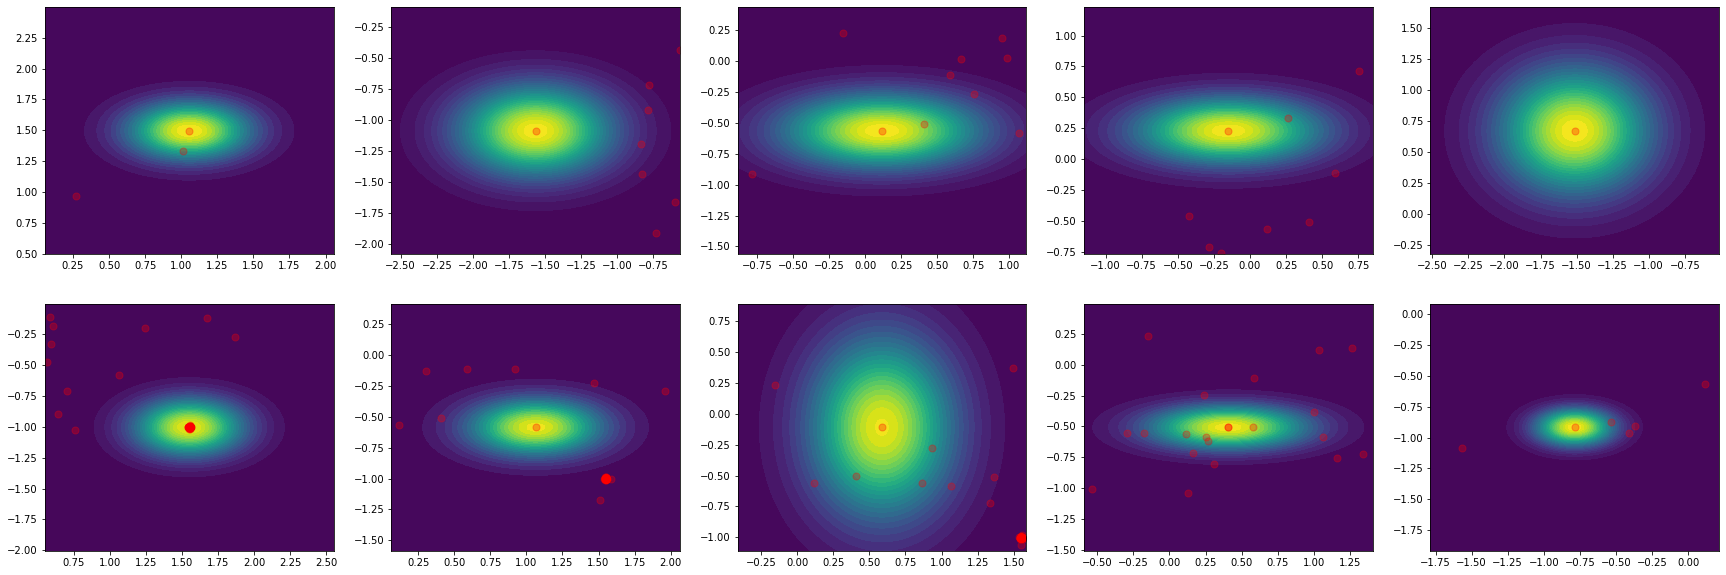

In [5]:
# Plotting
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(length):
    dist.plot_2d(dim=i, ax=ax.flatten()[i])
    ax.flatten()[i].scatter(particles[:, i, 0].numpy(), particles[:, i, 1].numpy(), s=50, c="red", alpha=0.3)
plt.show()

In [17]:
# Batch optimization using Path Signature
n_iter = 500
static_kernel = sigkernel.RBFKernel(sigma=0.5)

def signature_kernel(X, Y, **kwargs):
    k_xx = sigkernel.SigKernel(static_kernel, dyadic_order=3).compute_Gram(X.double(), Y.double())
    return k_xx.float()

stein_sampler = SVGD(signature_kernel, log_p=dist.log_prob, optimizer_class=torch.optim.Adam, lr=0.1)

stein_sampler.optimize(particles, n_steps=n_iter)
particles = particles.detach()

IndexError: tuple index out of range

In [7]:
dist.dists[0].mean

tensor([1.0556, 1.4968])